In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Change to repo root directory (parent of 'analysis' folder)
# In Jupyter, we can use the notebook's directory or go up from current directory
current_dir = Path.cwd()
if current_dir.name == 'analysis':
    # If we're in the analysis folder, go up one level
    repo_root = current_dir.parent
elif 'analysis' in current_dir.parts:
    # If analysis is in the path, find repo root
    idx = current_dir.parts.index('analysis')
    repo_root = Path(*current_dir.parts[:idx])
else:
    # Otherwise, assume we're already at repo root or need to navigate
    repo_root = Path('/Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis')

os.chdir(repo_root)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis


In [2]:
# Read CSV, skipping the extra header rows (TrackMate exports have multiple header rows)
# Row 0: actual column names (keep as header)
# Row 1-3: descriptive headers we want to skip
edges_path = 'results/trial_3/20260206_224003_subset_edges.csv'
spots_path = 'results/trial_3/20260206_224003_subset_spots.csv'
edges = pd.read_csv(edges_path, header=0, skiprows=[1, 2, 3])  # Keep row 0 as header, skip rows 1-3
spots = pd.read_csv(spots_path, header=0, skiprows=[1, 2, 3])

print(f"DataFrame shape: {edges.shape}")
print(f"\nColumns: {edges.columns.tolist()}")
edges.head()

DataFrame shape: (10719, 13)

Columns: ['LABEL', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID', 'LINK_COST', 'DIRECTIONAL_CHANGE_RATE', 'SPEED', 'DISPLACEMENT', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION', 'EDGE_Z_LOCATION', 'MANUAL_EDGE_COLOR']


,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,249.699022,0.0,NaN
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,249.642027,0.0,NaN
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,249.646044,0.0,NaN
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,250.393479,0.0,NaN
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,248.905988,0.0,NaN


In [3]:
spots.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX
0,ID555081,555081,0,256.0,190.285113,249.124595,0.0,2.0,2,9.053441,...,0.312021,10.501882,8.393338,1.116109,1.251216,257.5,69.509440,0.669730,0.894097,4.331668
1,ID554826,554826,0,321.0,191.558489,250.710663,0.0,0.0,0,10.124020,...,0.327645,13.686488,7.861003,0.975135,1.741061,322.0,86.968336,0.534987,0.824584,4.846556
2,ID555274,555274,0,261.0,191.494220,250.146757,0.0,5.0,5,9.088532,...,0.143661,11.585449,7.554834,0.967845,1.533515,259.5,84.043829,0.461674,0.803406,5.217196
3,ID557258,557258,0,298.0,193.309764,250.383838,0.0,16.0,16,9.723067,...,0.411175,12.673752,8.003717,0.935217,1.583483,297.0,85.337007,0.512497,0.838983,4.951755
4,ID554635,554635,0,261.0,190.137349,248.687380,0.0,1.0,1,9.123488,...,-0.032827,10.472385,8.168952,1.146933,1.281974,261.5,71.671677,0.639715,0.874582,4.432122


In [4]:
# merge edges with spots twice

# Select only the columns we need from spots (position and time)
spot_cols_needed = ['ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']

# First merge: get source spot positions
merged = edges.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_SOURCE_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_source' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_source',
    'POSITION_Y': 'POSITION_Y_source', 
    'POSITION_T': 'POSITION_T_source'
})
# Drop the 'ID' column from spots (we don't need it anymore)
merged = merged.drop(columns=['ID'])

# Second merge: get target spot positions
merged = merged.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_TARGET_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_target' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_target',
    'POSITION_Y': 'POSITION_Y_target',
    'POSITION_T': 'POSITION_T_target'
})
# Drop the 'ID' column again
merged = merged.drop(columns=['ID'])

In [5]:
merged.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,249.699022,0.0,NaN,191.558489,250.710663,0.0,190.137349,248.687380,1.0
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,249.642027,0.0,NaN,190.285113,249.124595,2.0,191.727027,250.159459,3.0
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,249.646044,0.0,NaN,191.727027,250.159459,3.0,191.460094,249.132629,4.0
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,250.393479,0.0,NaN,191.419975,250.091052,8.0,192.156140,250.695906,9.0
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,248.905988,0.0,NaN,190.137349,248.687380,1.0,190.285113,249.124595,2.0


In [6]:
delta_T = merged['POSITION_T_target'] - merged['POSITION_T_source']
merged['V_x'] = merged['POSITION_X_target'] - merged['POSITION_X_source'] / delta_T
merged['V_y'] = merged['POSITION_Y_target'] - merged['POSITION_Y_source'] / delta_T

In [7]:
merged.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,...,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target,V_x,V_y
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,...,0.0,NaN,191.558489,250.710663,0.0,190.137349,248.687380,1.0,-1.421140,-2.023282
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,...,0.0,NaN,190.285113,249.124595,2.0,191.727027,250.159459,3.0,1.441914,1.034864
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,...,0.0,NaN,191.727027,250.159459,3.0,191.460094,249.132629,4.0,-0.266933,-1.026830
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,...,0.0,NaN,191.419975,250.091052,8.0,192.156140,250.695906,9.0,0.736166,0.604854
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,...,0.0,NaN,190.137349,248.687380,1.0,190.285113,249.124595,2.0,0.147765,0.437215


In [8]:
# validate VELOCITY == SPEED 
merged['VELOCITY'] = np.sqrt(merged['V_x'] ** 2 + merged['V_y'] ** 2)
print('Magnitude of velocity and speed are equal: ' + str(all(np.isclose(np.abs(merged['VELOCITY']), merged['SPEED'], rtol=1e-05))))

Magnitude of velocity and speed are equal: False


In [9]:
# unit vector direction components of the wave
wave_x_unit = -0.875
wave_y_unit = -0.485

In [10]:
# Normalize velocity to unit vector
V_x = merged['V_x']
V_y = merged['V_y']

velocity_magnitude = np.sqrt(V_x**2 + V_y**2)
V_x_unit = V_x / velocity_magnitude
V_y_unit = V_y / velocity_magnitude

# Dot product with wave unit vector
merged['cosine'] = V_x_unit * wave_x_unit + V_y_unit * wave_y_unit

# Sort by closest to 1 (most aligned)
sorted_by_alignment = merged.sort_values('cosine', ascending=False)
sorted_by_alignment['cosine']

4236    1.000425
7254    1.000425
8531    1.000424
9877    1.000424
2880    1.000424
          ...   
5208   -1.000420
1406   -1.000421
4632   -1.000423
5110   -1.000423
4445   -1.000425
Name: cosine, Length: 10719, dtype: float64

In [11]:
# Parallel component (along wave direction)
merged['V_parallel'] = V_x * wave_x_unit + V_y * wave_y_unit

# Orthogonal component (projection/perpendicular to wave)
merged['V_orthogonal'] = V_x * (-wave_y_unit) + V_y * wave_x_unit  # rotate wave vector 90°
sorted_by_orthogonality = merged.sort_values('V_orthogonal', ascending=False) # note: NOT unit
sorted_by_orthogonality['V_orthogonal']

1989     16.024197
1965      9.352328
6080      7.709038
7359      7.240613
5150      6.456006
           ...    
5371   -209.365564
682    -214.686290
3311   -215.586719
6724   -218.739642
8602   -221.491572
Name: V_orthogonal, Length: 10719, dtype: float64

In [12]:
# Extract V_parallel and V_orthogonal as Series
V_parallel = merged['V_parallel']
V_orthogonal = merged['V_orthogonal']

print(f"V_parallel: {len(V_parallel)} values")
print(f"V_orthogonal: {len(V_orthogonal)} values")
print(f"\nV_parallel stats:")
print(V_parallel.describe())
print(f"\nV_orthogonal stats:")
print(V_orthogonal.describe())

V_parallel: 10719 values
V_orthogonal: 10719 values

V_parallel stats:
count    10719.000000
mean        -8.346823
std         45.751933
min       -450.522055
25%         -0.328527
50%         -0.044670
75%          0.207084
max         16.621273
Name: V_parallel, dtype: float64

V_orthogonal stats:
count    10719.000000
mean        -3.279685
std         19.494541
min       -221.491572
25%         -0.258896
50%          0.033516
75%          0.326012
max         16.024197
Name: V_orthogonal, dtype: float64


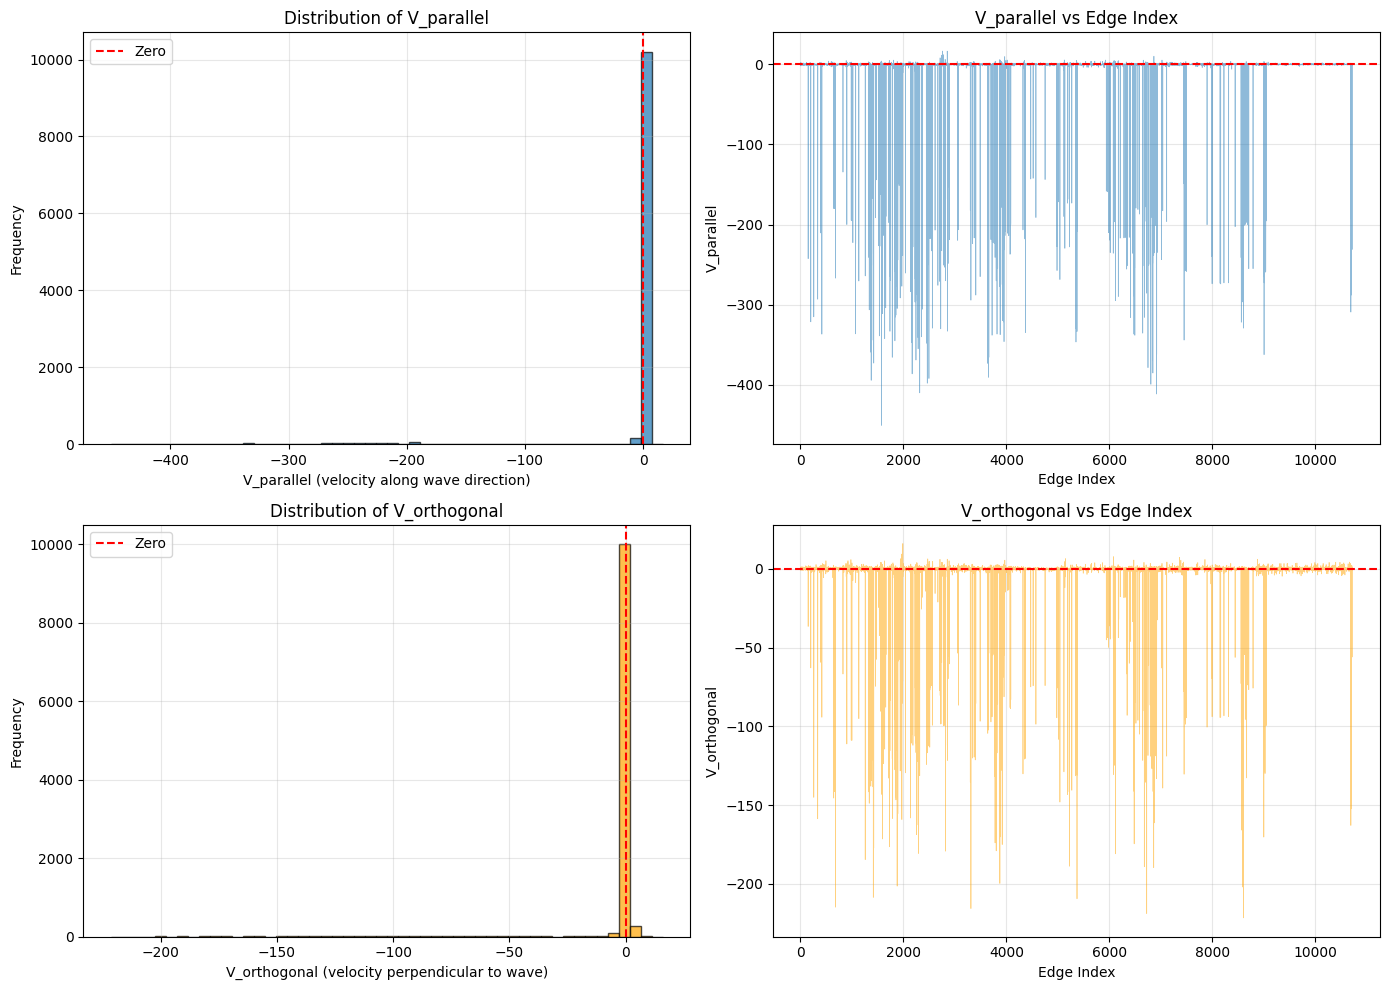

In [13]:
# Create plots for V_parallel and V_orthogonal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# V_parallel plots
axes[0, 0].hist(V_parallel, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('V_parallel (velocity along wave direction)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of V_parallel')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(V_parallel.index, V_parallel.values, alpha=0.5, linewidth=0.5)
axes[0, 1].set_xlabel('Edge Index')
axes[0, 1].set_ylabel('V_parallel')
axes[0, 1].set_title('V_parallel vs Edge Index')
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].grid(True, alpha=0.3)

# V_orthogonal plots
axes[1, 0].hist(V_orthogonal, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('V_orthogonal (velocity perpendicular to wave)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of V_orthogonal')
axes[1, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(V_orthogonal.index, V_orthogonal.values, alpha=0.5, linewidth=0.5, color='orange')
axes[1, 1].set_xlabel('Edge Index')
axes[1, 1].set_ylabel('V_orthogonal')
axes[1, 1].set_title('V_orthogonal vs Edge Index')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

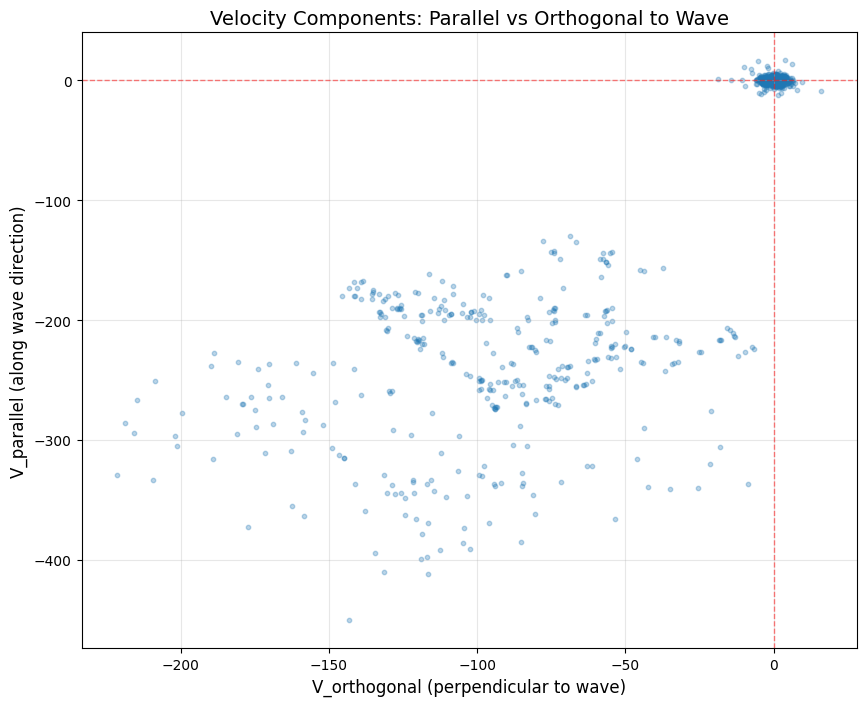

Quadrant Analysis:
Q1 (V_orthogonal > 0, V_parallel > 0): 2706 edges
Q2 (V_orthogonal < 0, V_parallel > 0): 2087 edges
Q3 (V_orthogonal < 0, V_parallel < 0): 2943 edges
Q4 (V_orthogonal > 0, V_parallel < 0): 2983 edges


In [14]:
# Scatter plot: V_parallel vs V_orthogonal
plt.figure(figsize=(10, 8))
plt.scatter(V_orthogonal, V_parallel, alpha=0.3, s=10)
plt.xlabel('V_orthogonal (perpendicular to wave)', fontsize=12)
plt.ylabel('V_parallel (along wave direction)', fontsize=12)
plt.title('Velocity Components: Parallel vs Orthogonal to Wave', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Print quadrant analysis
print("Quadrant Analysis:")
print(f"Q1 (V_orthogonal > 0, V_parallel > 0): {((V_orthogonal > 0) & (V_parallel > 0)).sum()} edges")
print(f"Q2 (V_orthogonal < 0, V_parallel > 0): {((V_orthogonal < 0) & (V_parallel > 0)).sum()} edges")
print(f"Q3 (V_orthogonal < 0, V_parallel < 0): {((V_orthogonal < 0) & (V_parallel < 0)).sum()} edges")
print(f"Q4 (V_orthogonal > 0, V_parallel < 0): {((V_orthogonal > 0) & (V_parallel < 0)).sum()} edges")